In [1]:
"""

Date: 18 March 2020

Python version:      3.7
Tensorboard version: 1.14.0
PyTorch version:     1.2.0

@author: Maksim Lavrov

Only one flexible layer with 12 output filters and with avgpool instead of maxpool in the flexilayer
But without the usual 2x2 maxpool following

Visualising a single threshold layer pixel to see if assymptotes

"""

# imports
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

#create a dataset subset to reduce training time

sampler_train = list(range(0, len(trainset), 500))
sampler_test = list(range(0, len(testset), 500))
trainset_samp = torch.utils.data.Subset(trainset, sampler_train)
testset_samp = torch.utils.data.Subset(testset, sampler_test)

#set size of batch and learning rate
batch_size=100
lr=0.001
wlr=0.005

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=4)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=4)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [2]:
#Xavier threshold initialization

def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform(m.threshold1)
        m.bias.data.fill_(0.01)

In [3]:
class FlexiLayer(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=True, padding_mode='zeros'):
        kernel_size = kernel_size
        stride = stride
        padding = padding
        dilation = dilation
        super(FlexiLayer, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            groups, bias, padding_mode)
        
        #mask
        #self.wconv = nn.parameter.Parameter(torch.empty(1, self.out_channels, 24, 24).normal_(mean=0.5,std=0.1))
        self.threshold1 = nn.parameter.Parameter((torch.empty(1, self.out_channels, 24, 24).normal_(mean=0.5,std=0.1)), requires_grad=True)
        self.apply(init_weights)
        self.memorized = self.threshold1.clone()
        self.memorized_1loop = []
        self.memorized_1pixel = []
        self.thresh_max = []
        self.thresh_min = []
        self.thresh_mean = []
            
    def forward(self, t):
        self.threshold1.expand(t.size(0), self.out_channels, 24, 24)
        #self.wconv.expand(t.size(0), self.out_channels, 24, 24)
        #self.wmax.expand(t.size(0), self.out_channels, 24, 24)
        
        t_1 = F.conv2d(t.cuda(), self.weight.cuda(), padding = self.padding) # get convolution result
        
        t_2 = F.max_pool2d(t.cuda(), kernel_size=self.kernel_size, stride=self.stride, padding = self.padding) # get max result with the same kernel size
        
        m = nn.Sigmoid()
        cond = torch.sub(self.threshold1.cuda(), t_2.cuda()) # THRESHOLD - MAX (broadcasting here)
        t_2_2 = m(cond*50)*t_2 # if condition is true - do MAX => THRESHOLD HIGHER
        t_1_1 = m(cond*(-50))*t_1 #  if condition is false - do CONV => THRESHOLD LOWER
        
        t_out = torch.add(t_2_2, t_1_1) # compute the output
        
        return t_out

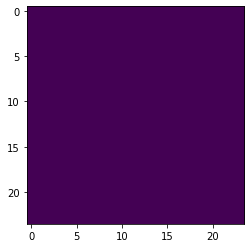

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flex1 = FlexiLayer(in_channels=1, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=4*12*12*12, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10) # number of classes

    def forward(self, t):
        
        # (2) Flexible layer
        t = self.flex1(t)
        
        t = F.relu(t)
        
        # (4) hidden linear layer
        t = F.relu(self.fc1(t.reshape(-1, 4 * 12 * 12 * 12)))
        
        # (5) hidden linear layer
        t = F.relu(self.fc2(t))
        
        # (6) output layer
        t = self.out(t)
        
        return t

net = Net()
"""
state_dict = net.state_dict()
thr = state_dict["flex1.threshold1"]
state_dict["flex1.threshold1"] = Variable(thr.data.new(1, 12, 24, 24).normal_(0.2,std=0.025)) # make a random tensor of same type and device as original
net.load_state_dict(state_dict)
"""


if torch.cuda.is_available():
  net.cuda()

memorized = net.flex1.memorized.clone()
#before training
imgplot = plt.imshow(net.flex1.threshold1.cpu().detach().numpy()[0,1,:] - memorized.cpu().detach().numpy()[0,1,:])

Text(0.5, 0, 'Threshold layer values')

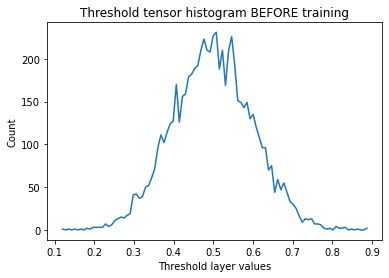

In [5]:
#Plot the new learned distribution
     
thresh_hist = torch.histc(net.flex1.threshold1)
start = np.min(net.flex1.threshold1.cpu().detach().numpy())
end = np.max(net.flex1.threshold1.cpu().detach().numpy())
xhist = torch.linspace(start,end,100) # histogram x-axis
plt.plot(xhist, thresh_hist.cpu().detach().numpy())
plt.title('Threshold tensor histogram BEFORE training')
plt.ylabel('Count')
plt.xlabel('Threshold layer values')

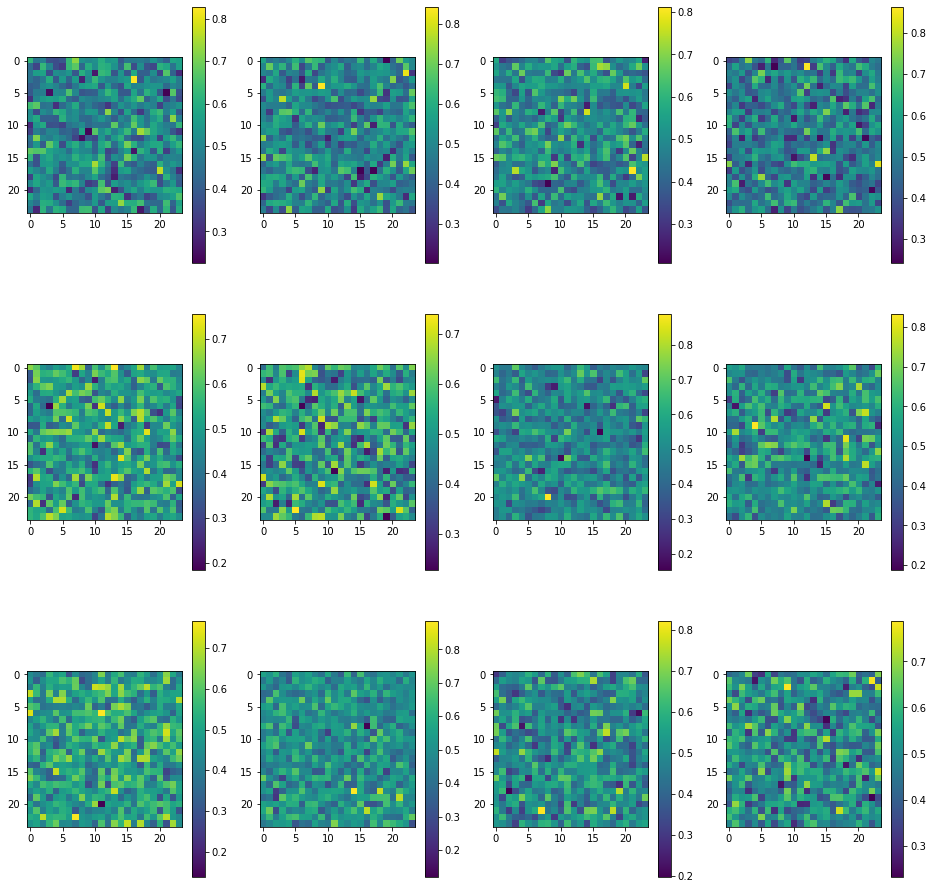

In [6]:
#before training

fig = plt.figure(figsize=(16,16))
plt.title('Threshold tensor values BEFORE training')
for idx in range(net.flex1.threshold1.size(1)):
    im = plt.subplot(3,4, idx + 1)
    imgplot = plt.imshow(net.flex1.threshold1.cpu().detach().numpy()[0,idx,:,:])
    plt.colorbar()

In [8]:
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer_flex = optim.Adam([{'params':[net.flex1.threshold1], 'lr':lr*1.2}], lr=lr)
optimizer = torch.optim.SGD(net.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)
#optimizer = torch.optim.SGD([{'params':[net.flex1.threshold1], 'lr':lr}],lr = 0.001,momentum = 0.9,weight_decay = 0.006)
schedule = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma = 0.7)


In [9]:
# helper functions

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

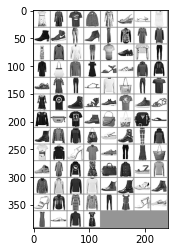

In [10]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
#writer.add_image('four_fake_images', img_grid)

In [11]:
images.mean()

tensor(-0.4362)

# plot the flex weights before training

fig = plt.figure()
plt.figure(figsize=(10,10))
plt.suptitle('Flexilayer weights before training', fontsize = 16)
for idx, filt  in enumerate(net.flex1.weight.detach().numpy()[:,0,:,:]):
    plt.subplot(3,4, idx + 1)
    plt.imshow(net.flex1.weight.detach().numpy()[idx,0,:,:], cmap="gray")

    
fig.show()

epoch: 0 loss: 79288.1654381752
epoch: 1 loss: 36194.85260248184
epoch: 2 loss: 29572.278174757957
epoch: 3 loss: 26062.6890540123
epoch: 4 loss: 24072.791317105293
epoch: 5 loss: 22630.923803150654
epoch: 6 loss: 21607.82609730959
epoch: 7 loss: 20857.667952775955
epoch: 8 loss: 20117.91140437126
epoch: 9 loss: 19500.11008530855
epoch: 10 loss: 18988.740175962448
epoch: 11 loss: 18654.748359322548
epoch: 12 loss: 18171.693556010723
epoch: 13 loss: 17670.875015854836
epoch: 14 loss: 17499.65124949813
epoch: 15 loss: 17088.359628617764
epoch: 16 loss: 16748.91055226326
epoch: 17 loss: 16479.577546566725
epoch: 18 loss: 16106.605573743582
epoch: 19 loss: 15917.512050271034
epoch: 20 loss: 15557.190623134375
epoch: 21 loss: 15323.696275055408
epoch: 22 loss: 15192.9523922503
epoch: 23 loss: 14907.137516885996
epoch: 24 loss: 14681.90676048398
epoch: 25 loss: 14487.818526476622
epoch: 26 loss: 14308.117546886206
epoch: 27 loss: 14116.053411364555
epoch: 28 loss: 13867.277108877897
epoch: 2

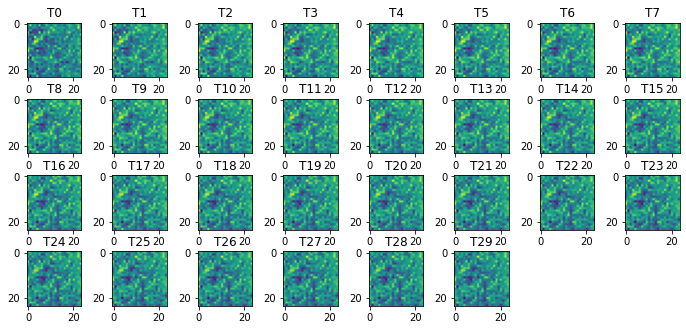

In [12]:
running_loss = 0.0
total_loss_plt = []
plt.figure(figsize=(12,12))
for epoch in range(30):  # loop over the dataset multiple times
    
    total_loss = 0
    total_correct = 0
    
    nsamples = 1000

    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        preds = net(inputs) # Pass batch

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.cuda())
        loss = criterion(outputs, labels.cuda())
        loss.backward()
        optimizer_flex.step()
        optimizer.step()
        
        total_loss += loss.item() * batch_size
        total_correct += get_num_correct(preds.cuda(), labels.cuda())
    
    
        if i == len(trainloader)-1:

            net.flex1.memorized_1pixel.append(net.flex1.threshold1.cpu().detach().numpy()[0,1,10,10])
            net.flex1.thresh_max.append(torch.max(net.flex1.threshold1))
            net.flex1.thresh_min.append(torch.min(net.flex1.threshold1))
            net.flex1.thresh_mean.append(torch.mean(net.flex1.threshold1))
            net.flex1.memorized_1loop = net.flex1.threshold1
            #at the end of every epoch plot threshold
            title = 'T'+str(epoch)
            plt.subplot(8,8, epoch + 1)
            plt.subplots_adjust(hspace=0.4, bottom=0.2)
            plt.title(title)
            imgplot = plt.imshow(net.flex1.threshold1.cpu().detach().numpy()[0,1,:])
            #imgplot = plt.imshow(net.flex1.memorized_1loop.detach().numpy()[0,1,:] - memorized.detach().numpy()[0,1,:])
            
    total_loss_plt.append(total_loss)
    
    print("epoch:", epoch, "loss:", total_loss)
        
print('Finished Training')

In [13]:
# ======================== Function to get the test accuracy ===============================================================================
def test():
  correct = 0
  total = 0
  net.train(False)
  with torch.no_grad():
    for i,(images,labels)in enumerate(testloader):
      if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
      outputs = net(Variable(images))
      labels = Variable(labels)
      _,predicted = outputs.max(1)
      total += labels.size(0)
      correct += (predicted.eq(labels)).sum().item()
    print('Test accuracy: %d %%' % (
  100 * correct / total))
  return 100*(correct/total)


#======================================= Testing ===================================================================================================
test_acc = test() # Test error
print(test_acc)

# Per class accuracy
class_correct = list(0. for i in range(10)) # Individual class error
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()
        images = Variable(images)
        labels = Variable(labels)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Test accuracy: 87 %
87.5
Accuracy of T-shirt/top : 82 %
Accuracy of Trouser : 98 %
Accuracy of Pullover : 79 %
Accuracy of Dress : 97 %
Accuracy of  Coat : 83 %
Accuracy of Sandal : 92 %
Accuracy of Shirt : 74 %
Accuracy of Sneaker : 95 %
Accuracy of   Bag : 98 %
Accuracy of Ankle Boot : 100 %


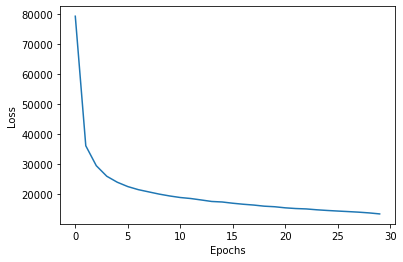

In [14]:
plt.plot(total_loss_plt)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

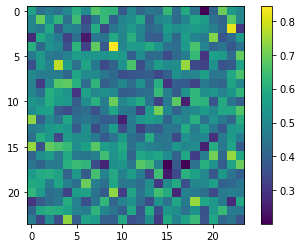

In [15]:
#before training
imgplot = plt.imshow(memorized.detach().numpy()[0,1,:])
plt.colorbar()

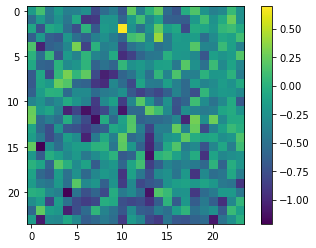

In [16]:
#after training
imgplot = plt.imshow(net.flex1.threshold1.cpu().detach().numpy()[0,1,:] - memorized.detach().numpy()[0,1,:])
plt.colorbar()

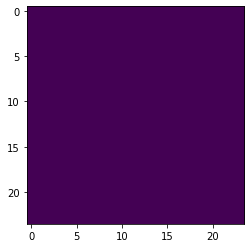

In [17]:
#after training single training loop
imgplot = plt.imshow(net.flex1.threshold1.cpu().detach().numpy()[0,1,:] - net.flex1.memorized_1loop.cpu().detach().numpy()[0,1,:])

# plot the flex weights after training

fig = plt.figure()
fig = plt.figure(figsize=(10,10))
plt.suptitle('Flexilayer weights after training', fontsize = 16)
for idx, filt  in enumerate(net.flex1.weight.cpu().detach().numpy()[:,0,:,:]):
    im = plt.subplot(3,4, idx + 1)
    plt.imshow(net.flex1.weight.cpu().detach().numpy()[idx,0,:,:], cmap="gray")
#plt.colorbar()

    
fig.show()

In [18]:
#after training
#print(net.flex1.memorized_1pixel)

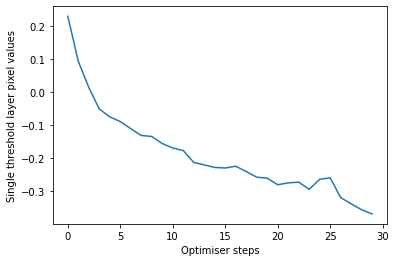

In [19]:
plt.plot(net.flex1.memorized_1pixel)
plt.ylabel('Single threshold layer pixel values')
plt.xlabel('Optimiser steps')
plt.show()

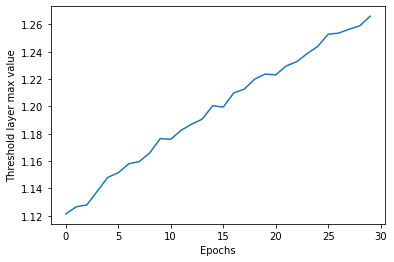

In [20]:
plt.plot(net.flex1.thresh_max)
plt.ylabel('Threshold layer max value')
plt.xlabel('Epochs')
plt.show()

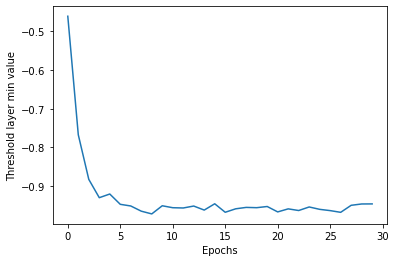

In [21]:

plt.plot(net.flex1.thresh_min)
plt.ylabel('Threshold layer min value')
plt.xlabel('Epochs')
plt.show()

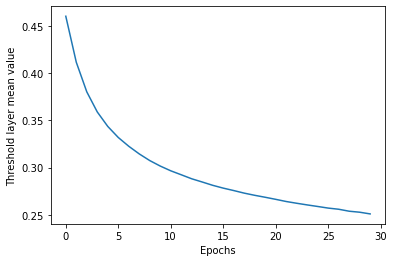

In [22]:
plt.plot(net.flex1.thresh_mean)
plt.ylabel('Threshold layer mean value')
plt.xlabel('Epochs')
plt.show()

path = "./models/FMNIST_FlexiLayer-avgpool-nomaxpool_20201803.pt"
torch.save(net.state_dict(), path)

<Figure size 432x288 with 0 Axes>

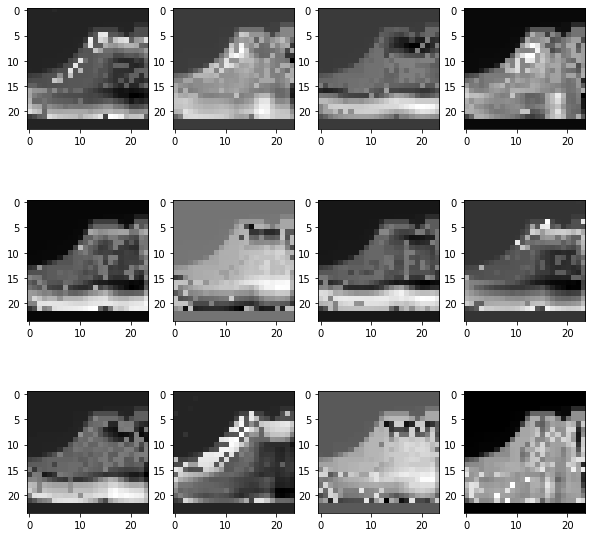

In [23]:
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

net.flex1.cpu().register_forward_hook(get_activation('flex1'))
data, _ = testset[0]
data.unsqueeze_(0)
output = net(data.cuda())


act = activation['flex1'].squeeze()
#fig, axarr = plt.subplots(act.size(0))
fig = plt.figure()
fig = plt.figure(figsize=(10,10))
for idx in range(act.size(0)):
    im = plt.subplot(3,4, idx + 1)
    plt.imshow(act.cpu()[idx,:,:], cmap="gray")
    #axarr[idx].imshow(act[idx], cmap="gray")

Text(0.5, 0, 'Threshold layer values')

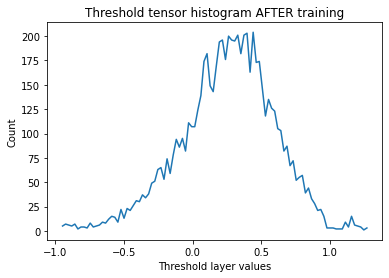

In [24]:
#Plot the new learned distribution
     
thresh_hist = torch.histc(net.flex1.threshold1)
start = np.min(net.flex1.threshold1.cpu().detach().numpy())
end = np.max(net.flex1.threshold1.cpu().detach().numpy())
xhist = torch.linspace(start,end,100) # histogram x-axis
plt.plot(xhist, thresh_hist.cpu().detach().numpy())
plt.title('Threshold tensor histogram AFTER training')
plt.ylabel('Count')
plt.xlabel('Threshold layer values')

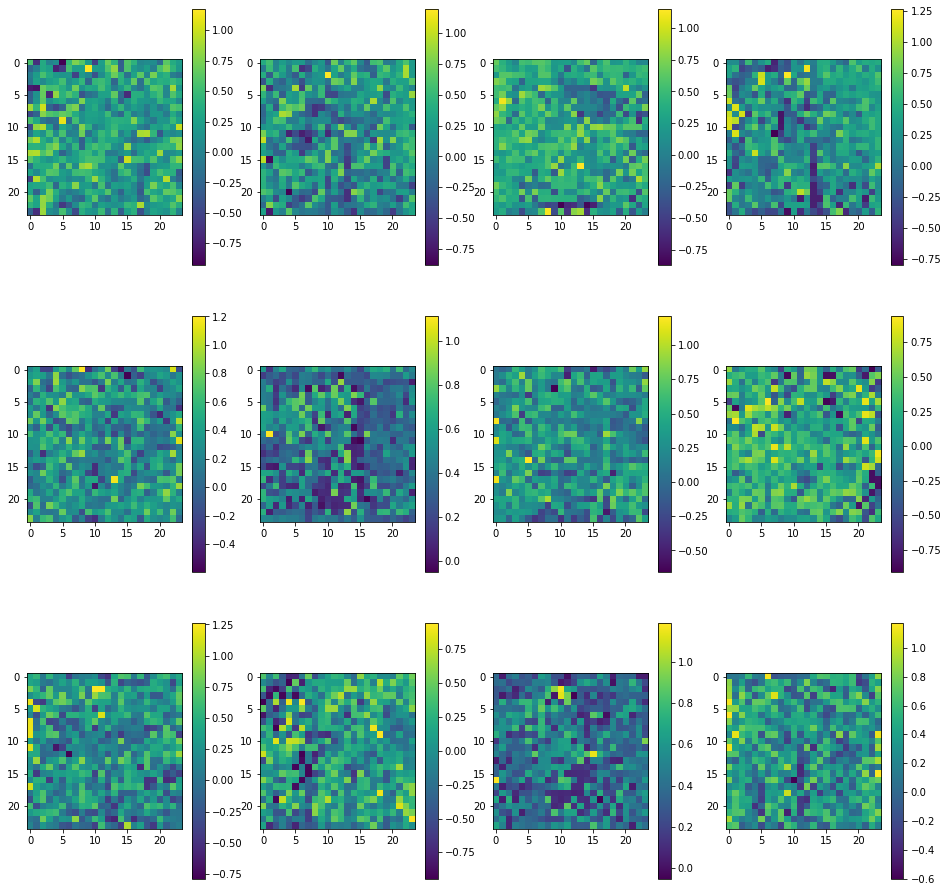

In [25]:
#after training

fig = plt.figure(figsize=(16,16))
plt.title('Threshold tensor values AFTER training')
for idx in range(net.flex1.threshold1.size(1)):
    im = plt.subplot(3,4, idx + 1)
    imgplot = plt.imshow(net.flex1.threshold1.cpu().detach().numpy()[0,idx,:,:])
    plt.colorbar()

Accuracy of the model w/0 adverserial attack on test images is : 87.5 %
Accuracy of the model with adverserial attack on test images is : 43.23 %
Number of misclassified examples(as compared to clean predictions): 4476/10000
True Label:  T-shirt/top   Predicted Label: T-shirt/top   Adverserial Label: Shirt
True Label:  Pullover   Predicted Label: Pullover   Adverserial Label: Coat


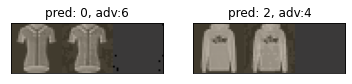

In [26]:
model = net
# ===============================================  Attack methods ===============================================================================

# FAST GRADIENT SIGN METHOD (FGSM)
def FGSM(test_loader,epsilon = 0.1,min_val = -1,max_val = 1):
  correct = 0                   # Fast gradient sign method
  adv_correct = 0
  misclassified = 0
  total = 0
  adv_noise =0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    images = Variable(images,requires_grad = True)
    labels = Variable(labels)
    
    outputs = model(images)
    loss =criterion(outputs,labels)

    model.zero_grad()
    if images.grad is not None:
      images.grad.data.fill_(0)
    loss.backward()
    
    grad = torch.sign(images.grad.data) # Take the sign of the gradient.
    images_adv = torch.clamp(images.data + epsilon*grad,min_val,max_val)     # x_adv = x + epsilon*grad
    
    adv_output = model(Variable(images_adv)) # output by the model after adding adverserial noise
    
    _,predicted = torch.max(outputs.data,1)      # Prediction on the clean image
    _,adv_predicted = torch.max(adv_output.data,1) # Prediction on the image after adding adverserial noise
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
    
  np.save('adverserial_images.npy',adverserial_images)    # Save the adverserial labels, images
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))




#  ITERATIVE - FGSM

def i_FGSM(test_loader,iterations = 1,epsilon = 0.1,min_val = -1,max_val = 1):
  correct = 0                # Iterative fast gradient sign method
  adv_correct = 0
  misclassified = 0
  total = 0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
      output_clean = model(Variable(images))
    images_adv = Variable(images.data,requires_grad = True)
    # Apply the FGSM for T iterations
    for j in range(iterations):  
      if torch.cuda.is_available():
        images_adv = images_adv.cuda()
      outputs = model(images_adv)
      loss = criterion(outputs,Variable(labels))
      
      model.zero_grad()
      if images_adv.grad is not None:
        images.adv.grad.data.fill_(0)
      
      loss.backward()
      grad = torch.sign(images_adv.grad.data)   # Get the sign of the gradient
      
      images_adv = images_adv + (epsilon/iterations)*grad  # X_n+1 = X_n + (epsilon/T)*grad   T = no. of iterations
       # Clip the image 
      images_adv = torch.where(images_adv > images + epsilon,images+epsilon,images_adv)
      images_adv = torch.where(images_adv < images-epsilon,images-epsilon,images_adv)
      images_adv = torch.clamp(images_adv,min_val,max_val)
      images_adv = Variable(images_adv.data,requires_grad = True)
      

    adv_output = model(Variable(images_adv))
    
    _,predicted = torch.max(output_clean.data,1)    # Ouput of the clean image
    _,adv_predicted = torch.max(adv_output.data,1) # Output of the image after adding adverserial noise
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())
    
  np.save('adverserial_images.npy',adverserial_images)
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))


# ========================================= Attack the model ============================================================================
'''  
The image lies between [0,1] but since I have trained the whole network on normalized input, Therefore the min_val = -2.117 and max_val = 2.64 and 
not {0,1}
We unnormalize the images for visualisation.
The values of epsilon has been chosen according to the normalized input
'''
#i_FGSM(testloader,iterations = 15,epsilon = 0.15,min_val = -2.117,max_val = 2.64) 
FGSM(testloader,epsilon = 0.1,min_val = -2.117,max_val = 2.64)

# ============================== Visualisation ===================================================================================================
adverserial_images = np.load('adverserial_images.npy')
y_preds = np.load('y_preds.npy')
y_preds_adv = np.load('y_preds_adv.npy')
test_images = np.load('test_images.npy')
test_label = np.load('test_label.npy')

c = adverserial_images - test_images  # Verify whether the max diff between the image and adverserial image in epsilon or not
c.max()

mean = np.array([0.485, 0.456, 0.406])
mean = mean[:,None,None]
std = np.array([0.229, 0.224, 0.225])
std = std[:,None,None]

# Get index of  all the images where the attack is succesful
attack = (y_preds != y_preds_adv)
indexes = []
for i in range(len(attack)):
  if attack[i] == True:
    indexes.append(i)

indexes = np.array(indexes)


# Plot the images 
plt_idx = 0
while plt_idx < 2:
    idx = np.random.choice(indexes)
    img = test_images[idx]
    adv_img = adverserial_images[idx]
    img = img*std + mean
    
    img = np.transpose(img,(1,2,0))
    img = img.clip(0, 1)
   
    adv_img = adv_img*std + mean
    adv_img =np.transpose(adv_img,(1,2,0))
    
    adv_img = adv_img.clip(0, 1)
    noise = adv_img - img
    noise = np.absolute(10*noise)  # Noise is multiplied by 10 for visualisation purpose
    noise = noise.clip(0, 1)
    
    
    
    if y_preds[idx] != y_preds_adv[idx]:
        disp_im = np.concatenate((img, adv_img,noise), axis=1)
        
        
        ax = plt.subplot(1,2,plt_idx+1)
        #ax.set_title(classes[test_label[idx]],classes[y_preds[idx]], classes[y_preds_adv[idx]] )
        ax.set_title("pred: {}, adv:{}".format(y_preds[idx], y_preds_adv[idx]))
        #plt.figure(figsize=(7,7))
        plt.imshow(disp_im, cmap="gray")
        plt.xticks([])
        plt.yticks([])
        plt_idx += 1
        print("True Label: ",classes[test_label[idx]]," ","Predicted Label:",classes[y_preds[idx]]," ", "Adverserial Label:",classes[y_preds_adv[idx]])
plt.show()

In [31]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

'''  
The image lies between [0,1] but since I have trained the whole network on normalized input, Therefore
the min_val = -2.117 and max_val = 2.64 and not {0,1}
'''

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, -2.117, 2.64)
    # Return the perturbed image
    return perturbed_image

def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        #if init_pred.item() != target.item():
        #    continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        for i in range(0,len(final_pred)-1):
            if final_pred[i].sub(target[i]) == 0:
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 5):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[i], final_pred[i], adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[i], final_pred[i], adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

accuracies2 = []
examples2 = []

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(net, device, testloader, eps)
    accuracies2.append(acc)
    examples2.append(ex)

CUDA Available:  True
Epsilon: 0	Test Accuracy = 8669 / 100 = 86.69
Epsilon: 0.05	Test Accuracy = 6805 / 100 = 68.05
Epsilon: 0.1	Test Accuracy = 5045 / 100 = 50.45
Epsilon: 0.15	Test Accuracy = 3574 / 100 = 35.74
Epsilon: 0.2	Test Accuracy = 2401 / 100 = 24.01
Epsilon: 0.25	Test Accuracy = 1379 / 100 = 13.79
Epsilon: 0.3	Test Accuracy = 709 / 100 = 7.09
